# 02 Results

Use this notebook to visualize final curves and compare experiments.

In [ ]:
import os

%cd "C:\Users\titou\OneDrive\Bureau\mva\xai\xaif"
print(os.getcwd())


C:\Users\titou\OneDrive\Bureau\mva\xai
C:\Users\titou\OneDrive\Bureau\mva\xai


[WinError 2] Le fichier spécifié est introuvable: './xaif'
C:\Users\titou\OneDrive\Bureau\mva\xai\xaif
491
chainsaw


RISE: 100%|██████████| 2000/2000 [04:07<00:00,  8.09it/s]


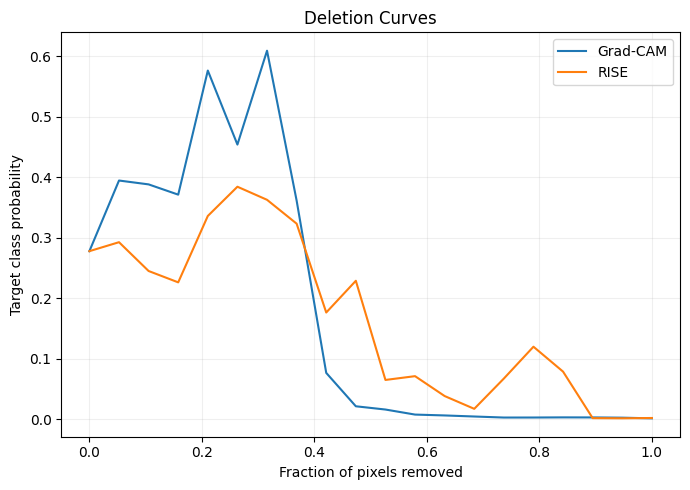

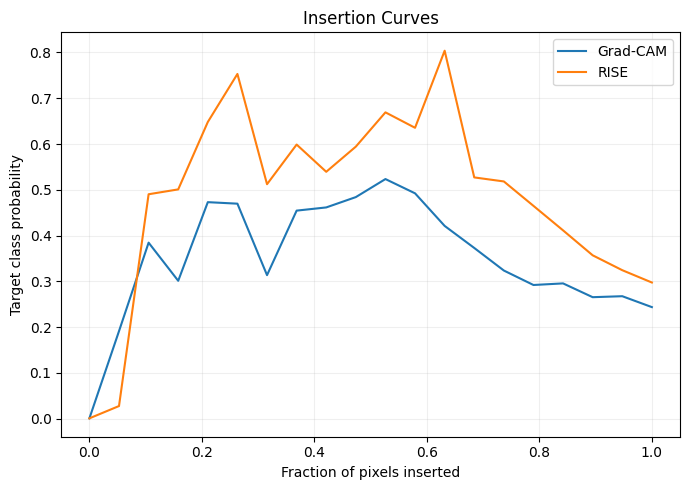

Deletion plot saved to: C:\Users\titou\OneDrive\Bureau\mva\xai\xaif\outputs\chainsaw_1505\eval\deletion_curves.png
Insertion plot saved to: C:\Users\titou\OneDrive\Bureau\mva\xai\xaif\outputs\chainsaw_1505\eval\insertion_curves.png
AUC deletion Grad-CAM: 0.1809
AUC deletion RISE: 0.1670
AUC insertion Grad-CAM: 0.3638
AUC insertion RISE: 0.5014


In [ ]:
from pathlib import Path
import json

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import auc
from torchvision.datasets import ImageFolder

from scripts.tools_for_data.data import image_to_tensor
from scripts.models.gradcam import compute_gradcam
from scripts.models.rise import compute_rise_saliency
from scripts.metrics.deletion import deletion_curve
from scripts.metrics.insertion import insertion_curve
from scripts.models.reset import get_resnet50, predict_class


# If notebook runs from xaif/notebooks, move to xaif root for clean relative paths
project_root = Path.cwd().resolve()
if project_root.name == 'notebooks':
    project_root = project_root.parent

data_root = project_root / 'data' / 'imagenette2-320' / 'val'
labels_path = project_root / 'data' / 'imagenet_labels.json'

with open(labels_path, "r", encoding="utf-8") as f:
    imagenet_labels = json.load(f)



dataset = ImageFolder(str(data_root))
sample_index = 1505  # <-- change this index
steps = 20
num_masks = 2000
device = 'cpu'  # or 'cuda'

image_path, _ = dataset.samples[sample_index]
image_path = Path(image_path)




model, _ = get_resnet50(device=device)
inp = image_to_tensor(image_path, image_size=224, device=device)
pred_class = predict_class(model, inp)
image_chw = inp[0].detach().cpu()


pred_class = predict_class(model, inp)
print(pred_class)
label = imagenet_labels[pred_class]
print(label)
safe_label = label.replace(" ", "_")

out_dir = project_root / 'outputs' / f'{safe_label}_{sample_index:04d}' / 'eval'
out_dir.mkdir(parents=True, exist_ok=True)

grad_map = compute_gradcam(model, inp, target_layers=[model.layer4[-1]], target_class=pred_class)
rise_map = compute_rise_saliency(model, inp, pred_class=pred_class, N=num_masks)

del_grad = deletion_curve(model, image_chw, grad_map, pred_class, steps=steps, device=device)
del_rise = deletion_curve(model, image_chw, rise_map, pred_class, steps=steps, device=device)
ins_grad = insertion_curve(model, image_chw, grad_map, pred_class, steps=steps, device=device)
ins_rise = insertion_curve(model, image_chw, rise_map, pred_class, steps=steps, device=device)

x = np.linspace(0, 1, steps)
auc_del_grad = auc(x, del_grad)
auc_del_rise = auc(x, del_rise)
auc_ins_grad = auc(x, ins_grad)
auc_ins_rise = auc(x, ins_rise)

x = np.linspace(0, 1, steps)

# -----------------------------
# Deletion curves
# -----------------------------
plt.figure(figsize=(7, 5))
plt.plot(x, del_grad, label='Grad-CAM')
plt.plot(x, del_rise, label='RISE')
plt.xlabel('Fraction of pixels removed')
plt.ylabel('Target class probability')
plt.title('Deletion Curves')
plt.grid(alpha=0.2)
plt.legend()
plt.tight_layout()
del_plot_path = out_dir / 'deletion_curves.png'
plt.savefig(del_plot_path, dpi=140)
plt.show()

# -----------------------------
# Insertion curves
# -----------------------------
plt.figure(figsize=(7, 5))
plt.plot(x, ins_grad, label='Grad-CAM')
plt.plot(x, ins_rise, label='RISE')
plt.xlabel('Fraction of pixels inserted')
plt.ylabel('Target class probability')
plt.title('Insertion Curves')
plt.grid(alpha=0.2)
plt.legend()
plt.tight_layout()
ins_plot_path = out_dir / 'insertion_curves.png'
plt.savefig(ins_plot_path, dpi=140)
plt.show()

print(f'Deletion plot saved to: {del_plot_path}')
print(f'Insertion plot saved to: {ins_plot_path}')
print(f'AUC deletion Grad-CAM: {auc_del_grad:.4f}')
print(f'AUC deletion RISE: {auc_del_rise:.4f}')
print(f'AUC insertion Grad-CAM: {auc_ins_grad:.4f}')
print(f'AUC insertion RISE: {auc_ins_rise:.4f}')